# Explore here

In [116]:
import numpy as np 
import pandas as pd 

import seaborn as sns 
import matplotlib.pyplot as plt 
from colorama import Fore
import missingno as msno
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from datetime import datetime, date
import warnings 
warnings.filterwarnings('ignore')

df = pd.read_csv("/workspaces/project-aceawater_joeld/data/interim/Aquifer_Petrignano.cvs")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


#  EDA

In [117]:
df.shape

(5223, 8)

In [118]:
# Visualizamos valores nulos 
df.isnull().sum()

Date                                       0
Rainfall_Bastia_Umbra                   1024
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25                  39
Temperature_Bastia_Umbra                1024
Temperature_Petrignano                  1024
Volume_C10_Petrignano                    198
Hydrometry_Fiume_Chiascio_Petrignano    1024
dtype: int64

<Axes: >

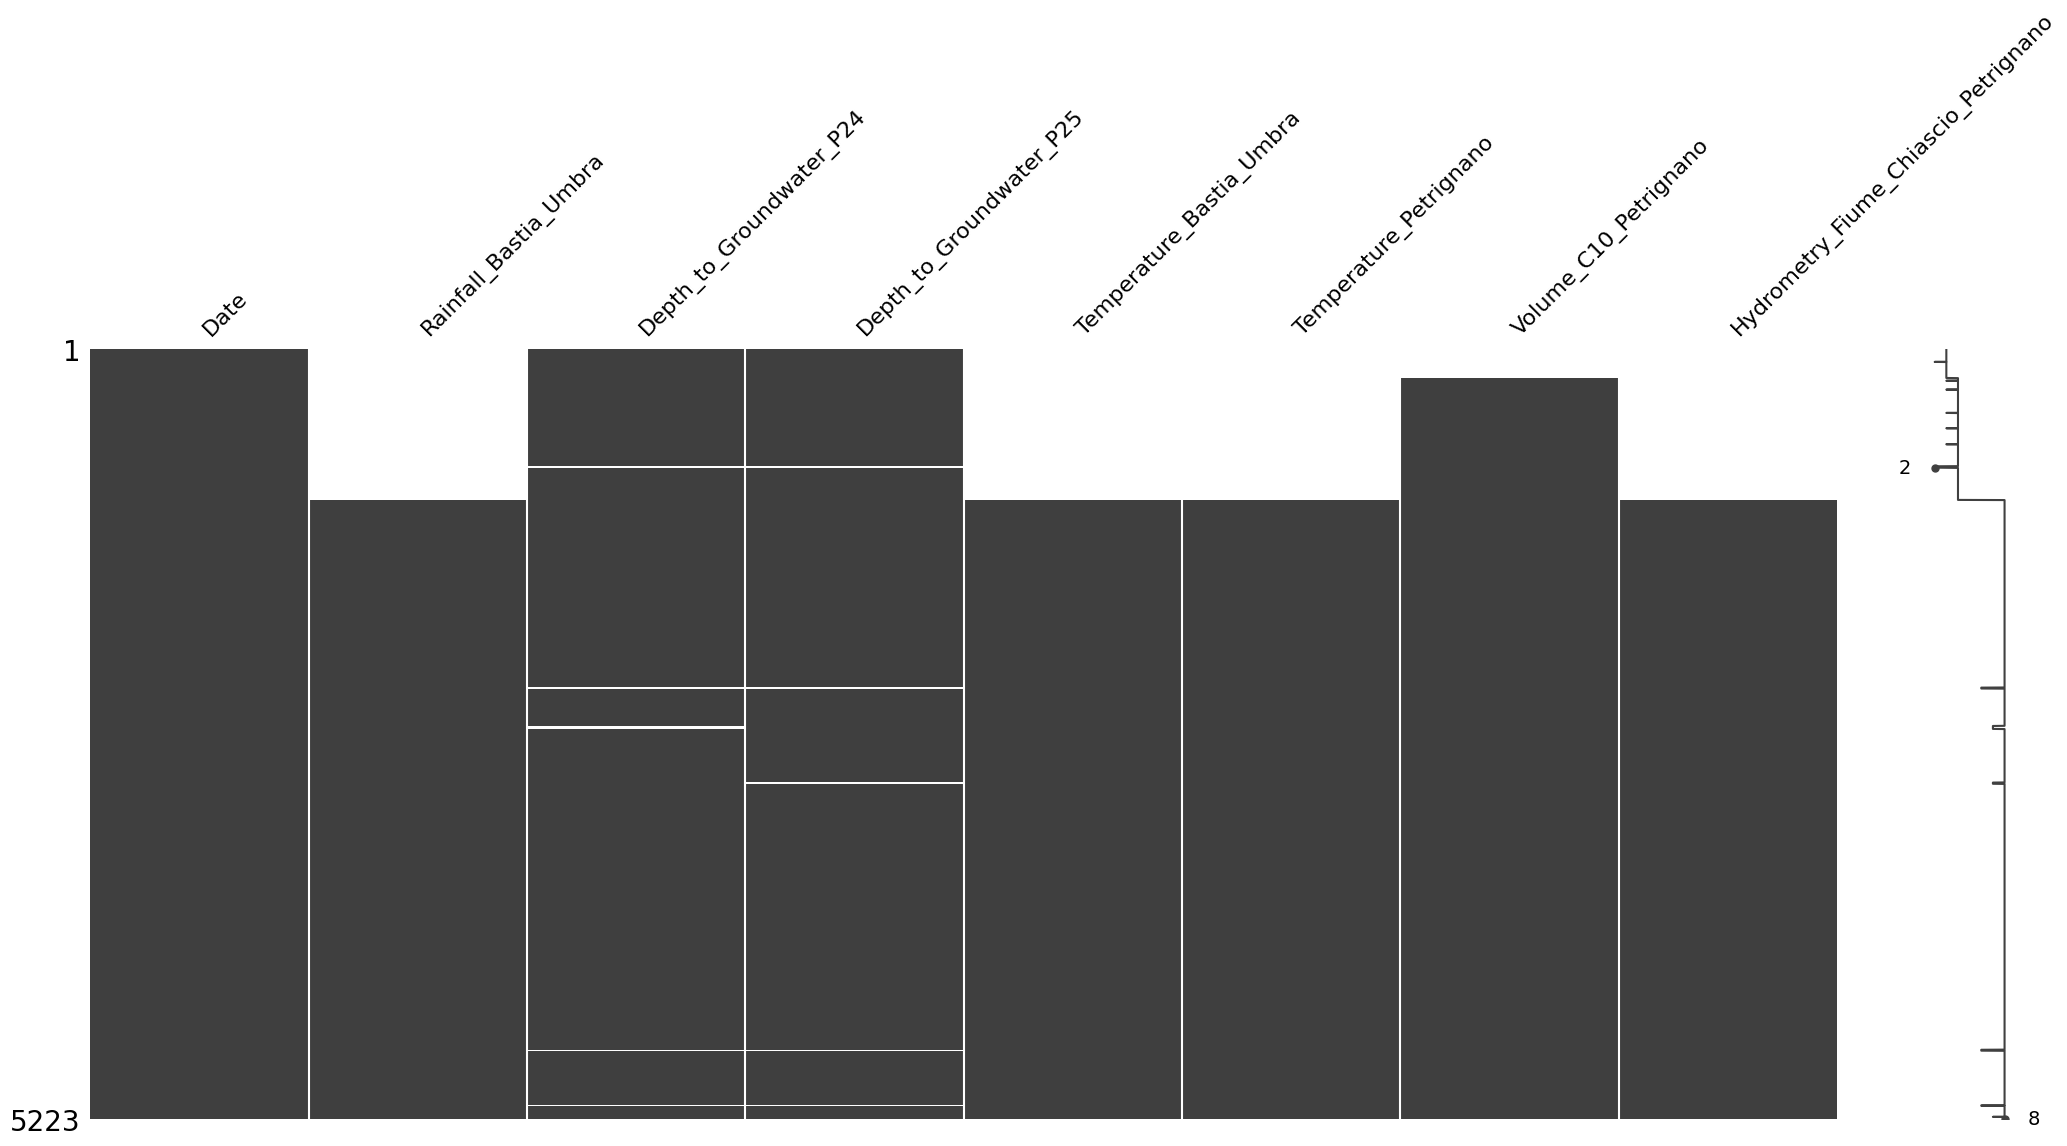

In [119]:
# observamos como se comportan los Valores nulos 
msno.matrix(df)

Como podemos ver el grueso de los valores nulos se encuentran en los datos mas viejos que tenemos vamos a proceder a quitar esos valores que entran en este patron tambien si analizamos las columnas hay 2 que no seran utiles para nosotros en este caso que son Depth_to_Groundwater_P24 y Temperature_Petrignano

In [120]:
#filtramos el df para eliminar las filas que tengan valores nulos en el Rainfall_Bastia_Umbra
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
#eliminamos columnas 
df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1,inplace=True)

In [121]:
#simplificamos los nombres de las columnas 

df.columns= ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [122]:
df['date'] = pd.to_datetime(df['date'] ,format = '%d/%m/%Y')

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  4199 non-null   datetime64[ns]
 1   rainfall              4199 non-null   float64       
 2   depth_to_groundwater  4172 non-null   float64       
 3   temperature           4199 non-null   float64       
 4   drainage_volume       4198 non-null   float64       
 5   river_hydrometry      4199 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 197.0 KB


Vamos a analizar como podemos trabajar los datos faltantes y revisaremos si los valores nulos que en principio tenemos son solo estos o al graficar nos daremos cuenta que tenemos mas valorews nulos 

In [124]:
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

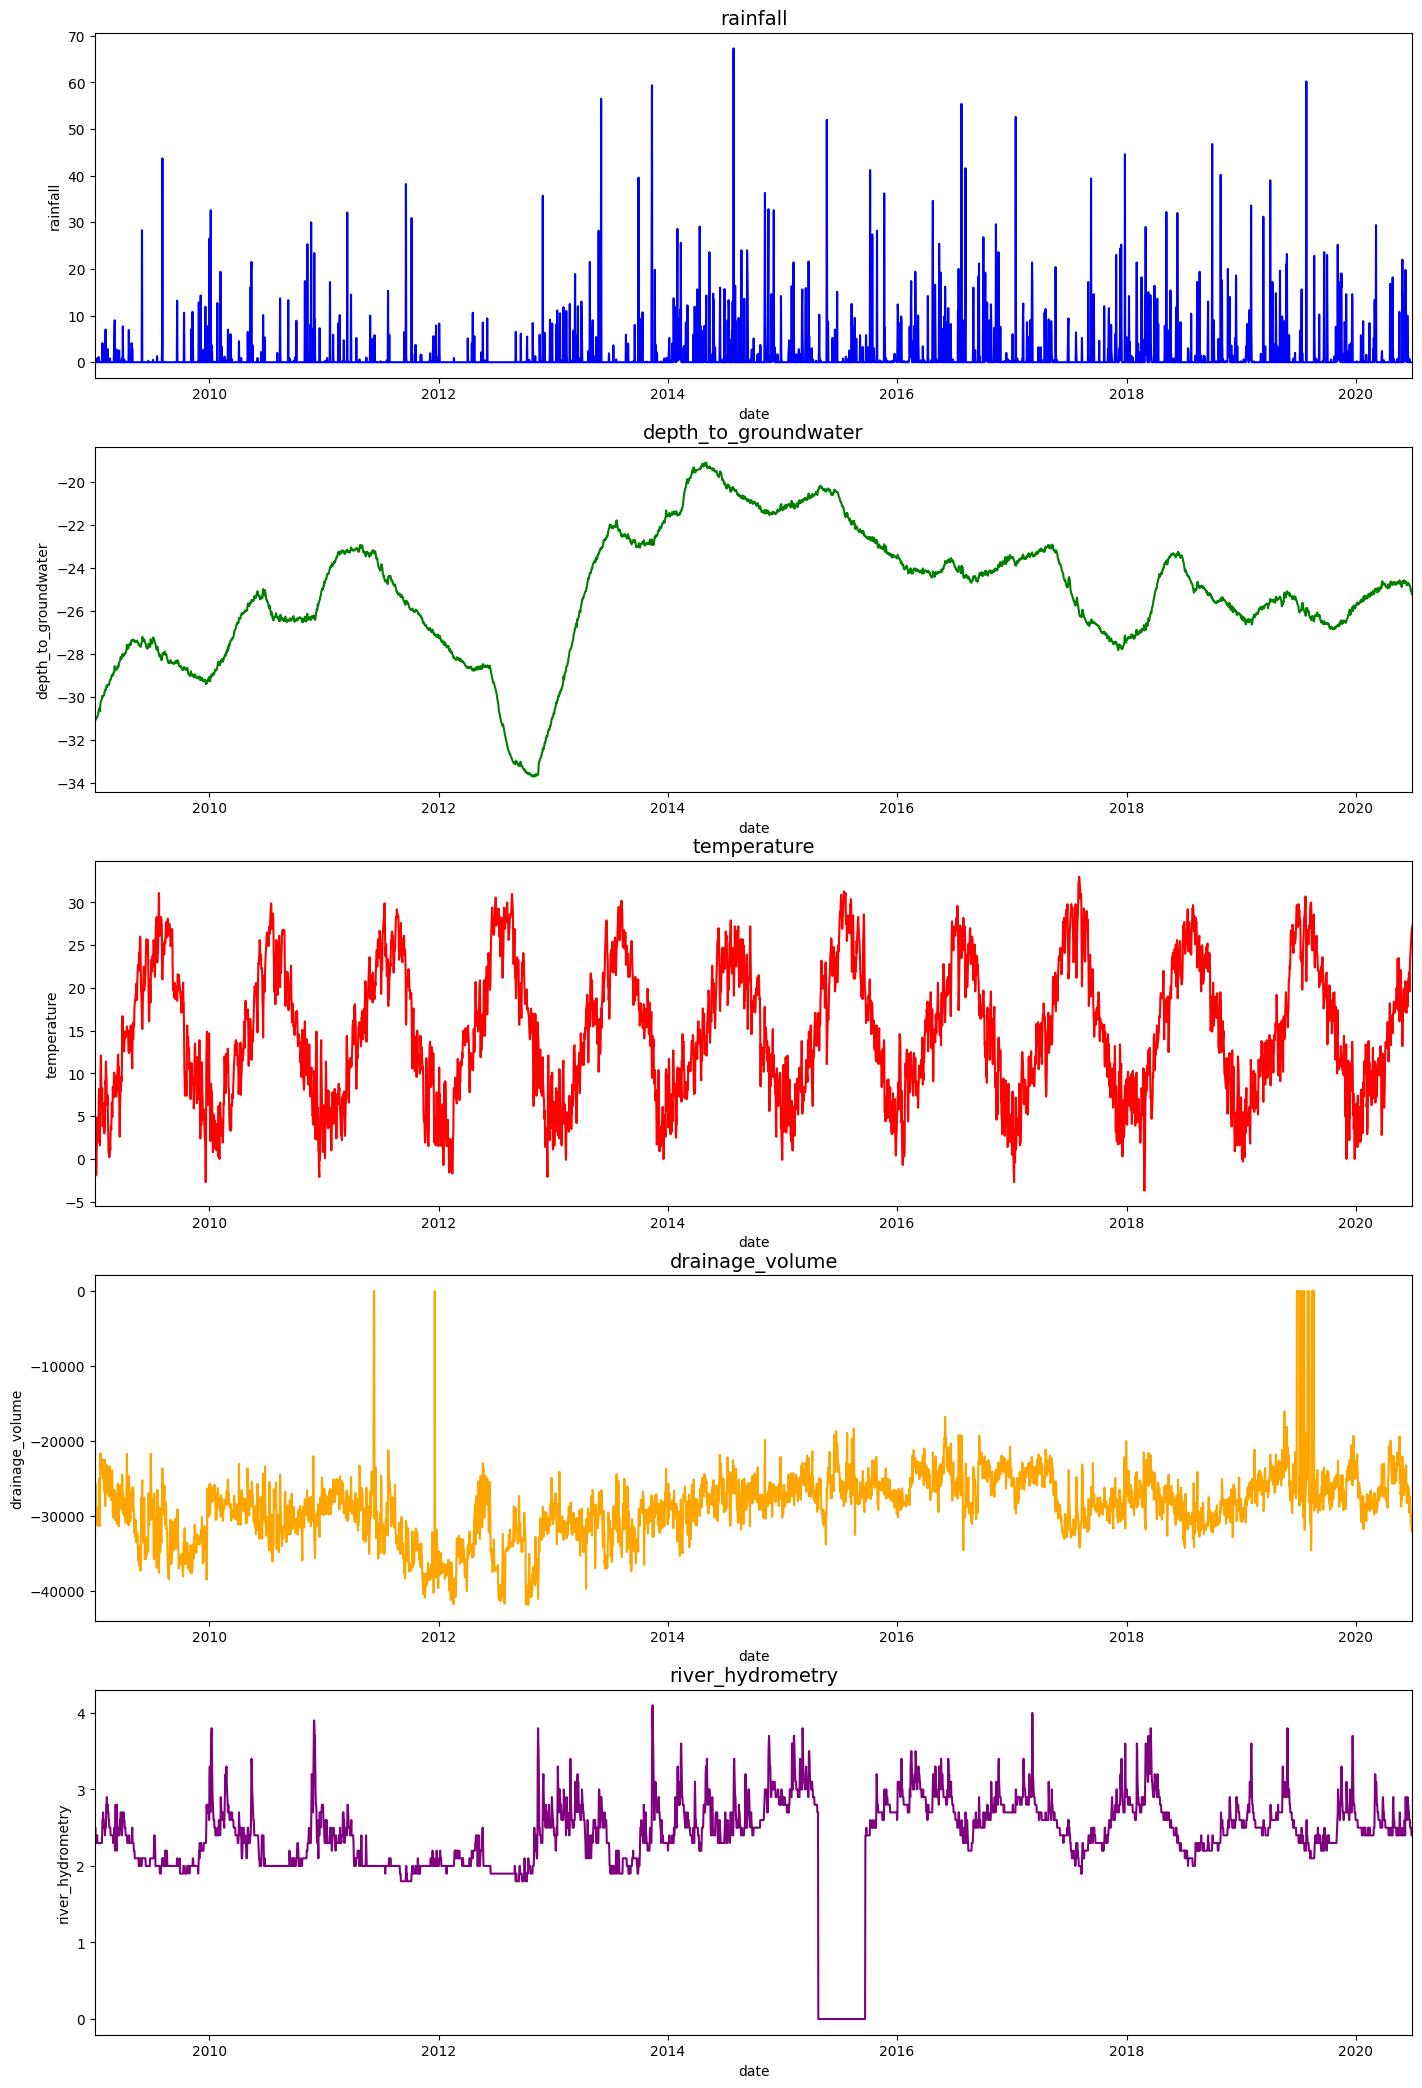

In [125]:
#Generamos los graficos y rellenamos los datos nulos 
colores = ['blue', 'green', 'red', 'orange', 'purple']

f, ax = plt.subplots(nrows=5, ncols=1, figsize=(17,26))

for i, col in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[col], ax=ax[i],color=colores[i])
    ax[i].set_title(col, fontsize=14)
    ax[i].set_ylabel(ylabel=col, fontsize=10)
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

Pues si miramos bien en los datos tanta river_htdrometry y drainage_volume tienen datos faltantes iguales a 0 vamos a trabajar estops datos a ver como los podemos imputar 

In [126]:
#creamos una variable con los datos originales para visualizarlos luego reemplazamos los datos iguales a 0 como nulos 

orig_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

orig_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

probaremos rellenar los datos con 2 metodos a ver cual es el mejor uno que sera con la media de la fila anterio y la siguiente y otro sera el metodo interpolate 

In [127]:
'''f, ax = plt.subplots(nrows=6, ncols=1, figsize=(20,30))

sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='red', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna((df['river_hydrometry'].ffill()+df['river_hydrometry'].bfill())/2), ax=ax[0], color='green', label='modified')
ax[0].set_title('Media Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2014, 6, 1), date(2016, 1, 30)])

sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[1], color='red', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].interpolate(), ax=ax[1], color='green', label='modified')
ax[1].set_title('interpolate Hydrometry', fontsize=14)
ax[1].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[1].set_xlim([date(2014, 6, 1), date(2016, 1, 30)])

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='red', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna((df['drainage_volume'].ffill()+df['drainage_volume'].bfill())/2), ax=ax[2], color='green', label='modified')
ax[2].set_title('Media Drainage', fontsize=14)
ax[2].set_ylabel(ylabel='Drainage', fontsize=14)
ax[2].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='red', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='green', label='modified')
ax[3].set_title('interpolate Drainage', fontsize=14)
ax[3].set_ylabel(ylabel='Drainage', fontsize=14)
ax[3].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])

sns.lineplot(x=df['date'], y=df['depth_to_groundwater'].fillna(np.inf), ax=ax[4], color='red', label='original')
sns.lineplot(x=df['date'], y=df['depth_to_groundwater'].fillna((df['depth_to_groundwater'].ffill()+df['depth_to_groundwater'].bfill())/2), ax=ax[4], color='green', label='modified')
ax[4].set_title('media depth_to_groundwater', fontsize=14)
ax[4].set_ylabel(ylabel='depth', fontsize=14)
ax[4].set_xlim([date(2014, 6, 1), date(2016, 1, 30)])


sns.lineplot(x=df['date'], y=df['depth_to_groundwater'].fillna(np.inf), ax=ax[5], color='red', label='original')
sns.lineplot(x=df['date'], y=df['depth_to_groundwater'].interpolate(), ax=ax[5], color='green', label='modified')
ax[5].set_title('media depth_to_groundwater', fontsize=14)
ax[5].set_ylabel(ylabel='depth', fontsize=14)
ax[5].set_xlim([date(2014, 6, 1), date(2016, 1, 30)])



plt.tight_layout()
plt.show()'''


"f, ax = plt.subplots(nrows=6, ncols=1, figsize=(20,30))\n\nsns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='red', label='original')\nsns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna((df['river_hydrometry'].ffill()+df['river_hydrometry'].bfill())/2), ax=ax[0], color='green', label='modified')\nax[0].set_title('Media Hydrometry', fontsize=14)\nax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)\nax[0].set_xlim([date(2014, 6, 1), date(2016, 1, 30)])\n\nsns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[1], color='red', label='original')\nsns.lineplot(x=df['date'], y=df['river_hydrometry'].interpolate(), ax=ax[1], color='green', label='modified')\nax[1].set_title('interpolate Hydrometry', fontsize=14)\nax[1].set_ylabel(ylabel='Hydrometry', fontsize=14)\nax[1].set_xlim([date(2014, 6, 1), date(2016, 1, 30)])\n\nsns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='red', label='original')\nsns.l

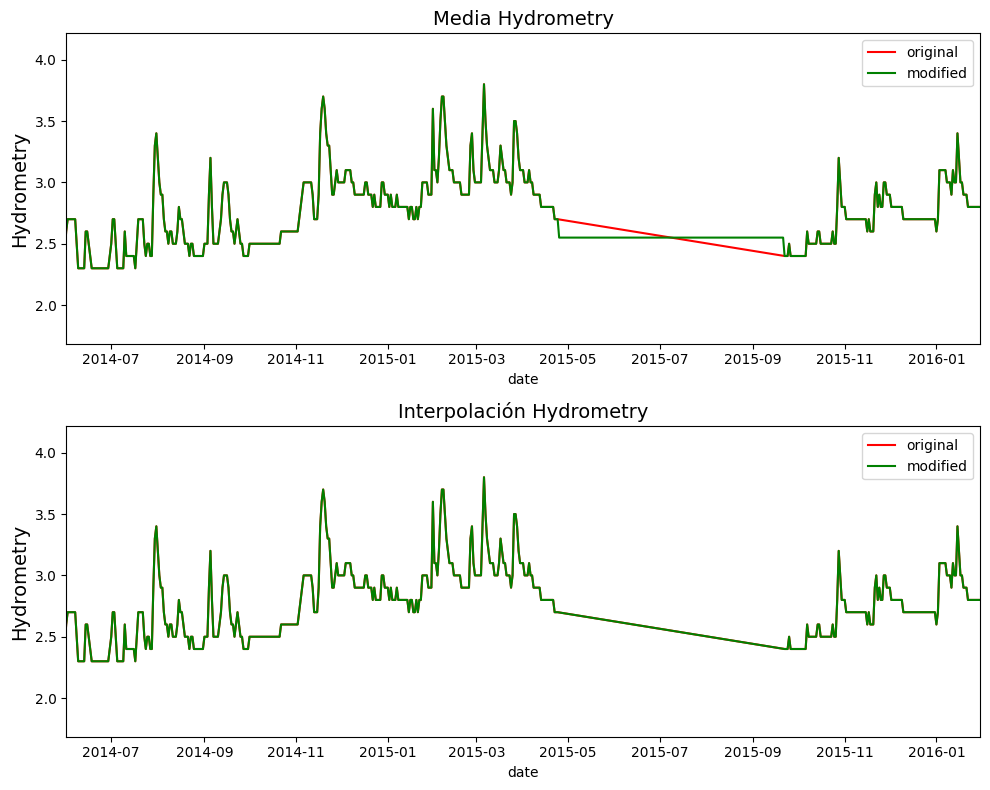

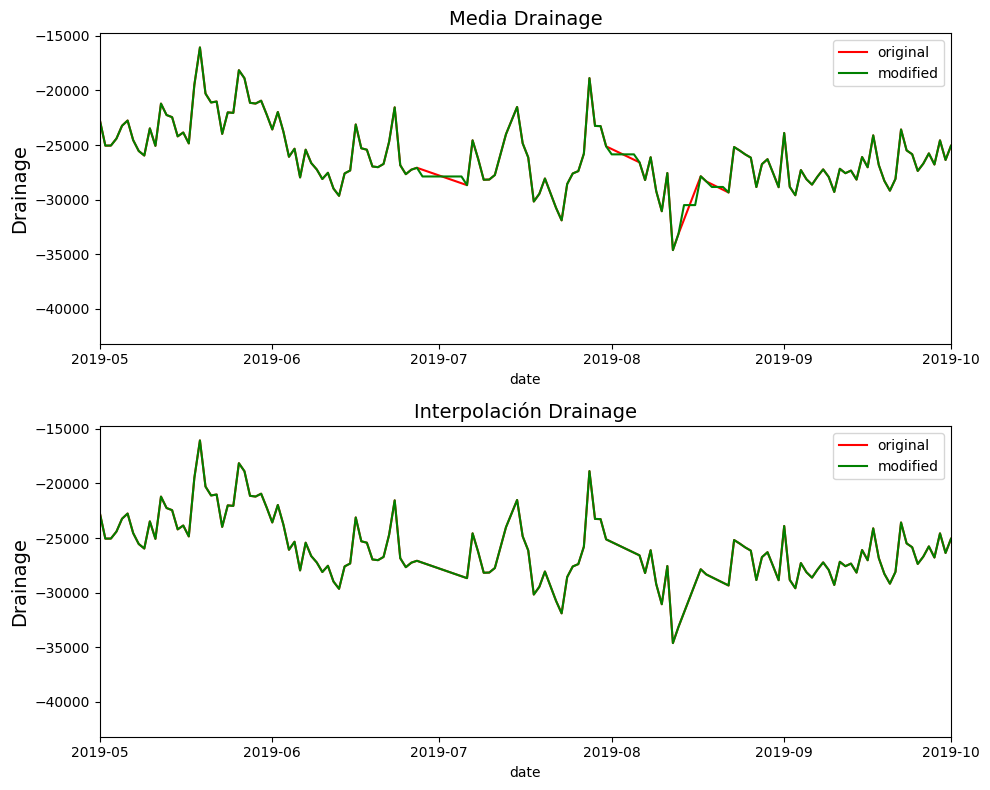

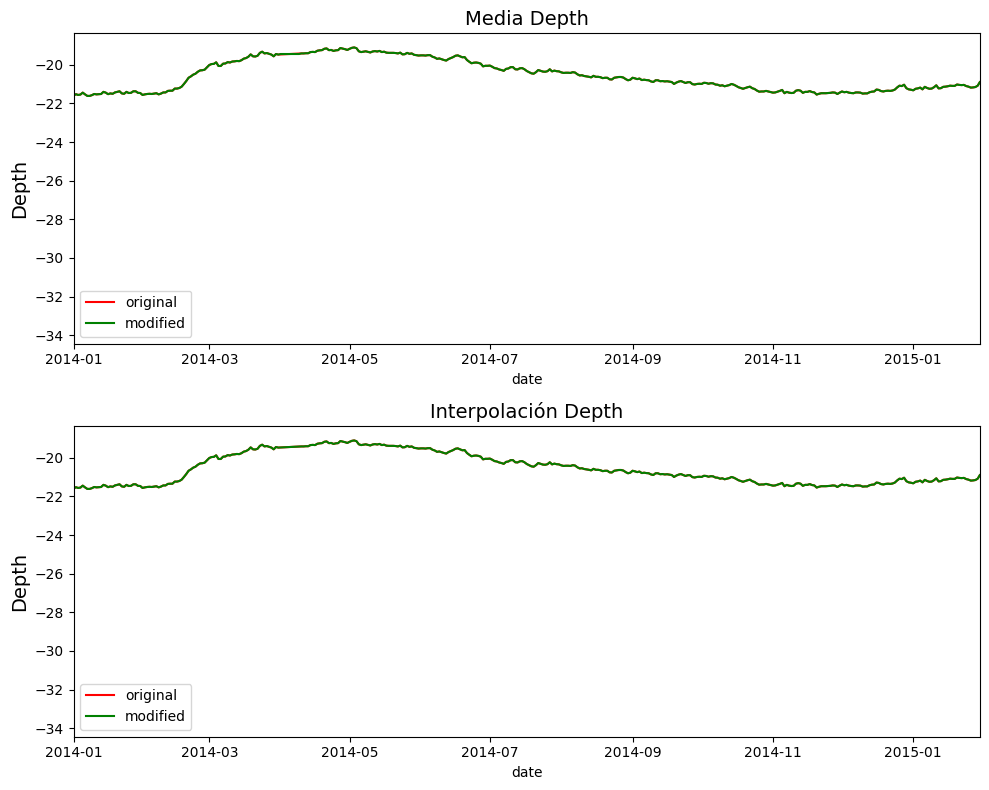

In [128]:
def plot_imputation_comparison(df, column, title_suffix, xlim=None):
    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

    # Línea original
    sns.lineplot(x=df['date'], y=df[column].fillna(np.inf), ax=ax[0], color='red', label='original')

    # Línea modificada con media
    sns.lineplot(x=df['date'], y=df[column].fillna((df[column].ffill() + df[column].bfill()) / 2), ax=ax[0], color='green', label='modified')
    ax[0].set_title(f'Media {title_suffix}', fontsize=14)
    ax[0].set_ylabel(ylabel=title_suffix, fontsize=14)
    if xlim:
        ax[0].set_xlim(xlim)

    # Línea original
    sns.lineplot(x=df['date'], y=df[column].fillna(np.inf), ax=ax[1], color='red', label='original')

    # Línea modificada con interpolate 
    sns.lineplot(x=df['date'], y=df[column].interpolate(), ax=ax[1], color='green', label='modified')
    ax[1].set_title(f'Interpolación {title_suffix}', fontsize=14)
    ax[1].set_ylabel(ylabel=title_suffix, fontsize=14)
    if xlim:
        ax[1].set_xlim(xlim)

    plt.tight_layout()
    plt.show()

# Ejemplo de uso
plot_imputation_comparison(df, 'river_hydrometry', 'Hydrometry', xlim=[date(2014, 6, 1), date(2016, 1, 30)])
plot_imputation_comparison(df, 'drainage_volume', 'Drainage', xlim=[date(2019, 5, 1), date(2019, 10, 1)])
plot_imputation_comparison(df, 'depth_to_groundwater', 'Depth', xlim=[date(2014, 1, 1), date(2015, 1, 30)])